# Relevance Vector Machine (Variational Sparse Gaussian Process)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VSGP
from kernels import RBF
from kernels import RVM
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

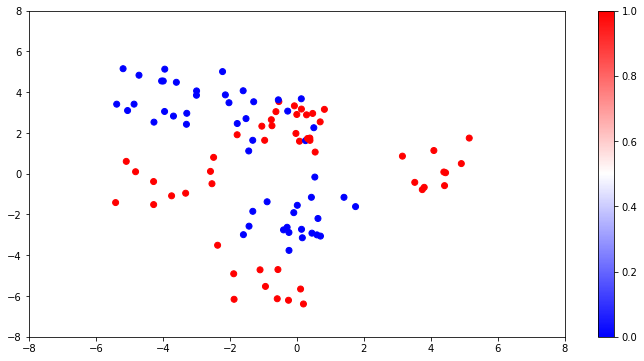

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

kernel = RVM(RBF(), X)
likelihood = Binary()
Z = X[:20, :].clone()
estimator = VSGP(Z, 1, kernel, likelihood, whiten = True)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_epochs = 1000
for epoch in range(n_epochs):
    loss = svi.step(X, y)
    if epoch % (n_epochs / 10) == 0:
        print(loss)

105.36123820891649
57.27847926148868
45.764572784611374
36.60409801564974
31.818981721917538
30.314183130668848
31.216513924288062
28.800284524522294
27.999279463550717
30.7346258799014


---

## 推論結果

### 予測分布

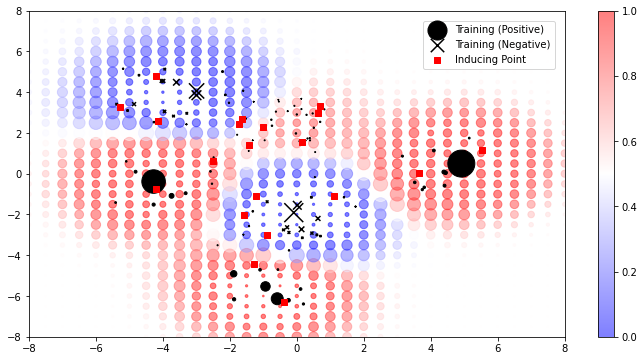

CPU times: user 11.7 s, sys: 1.22 s, total: 12.9 s
Wall time: 3.42 s


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)
    
    sr = estimator.kernel.relevance
    sr = (sr - sr.min()) / sr.std() * 100 + 1
    sp = pnew_std[:, 0]
    sp = ((sp - sp.min()) / sp.std()) * 50 + 1

    plt.figure(figsize = (12, 6))
    plt.scatter(
        x = Xnew[:, 0], y = Xnew[:, 1],
        s = sp,
        c = pnew_mean[:, 0], cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5,
        marker = "o"
    )
    plt.colorbar()
    plt.scatter(
        x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1],
        s = sr[y[:, 0] == 1],
        c = "black",
        marker = "o",
        label = "Training (Positive)"
    )
    plt.scatter(
        x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1],
        s = sr[y[:, 0] == 0],
        c = "black",
        marker = "x",
        label = "Training (Negative)"
    )
    plt.scatter(x = estimator.Z[:, 0], y = estimator.Z[:, 1], c = "red", marker = "s", label = "Inducing Point")
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend(bbox_to_anchor = (1, 1), loc = "upper right", borderaxespad = 1)
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.relevance

tensor([2.3892e-01, 3.6095e+00, 1.7846e+02, 1.2762e-01, 3.5091e-01, 7.0938e-01,
        1.5483e+00, 1.7052e+00, 2.5718e-01, 6.3622e-01, 2.1098e-01, 3.6368e+00,
        1.5215e+00, 2.1467e-01, 4.8378e-01, 2.1951e-01, 3.1694e+00, 1.1176e+00,
        2.2121e-01, 3.2576e-01, 1.3489e-01, 4.7000e-01, 3.4343e+00, 4.0352e-01,
        1.9135e+00, 1.4754e+00, 2.5266e+00, 1.8561e+00, 4.0412e-01, 1.1258e+00,
        1.2855e-01, 1.3371e+00, 6.3485e-01, 2.2025e-01, 2.4794e-01, 8.0954e-01,
        3.5036e+01, 7.7696e+00, 2.4931e-01, 1.6387e+00, 2.3136e-01, 1.4048e+00,
        1.1271e+00, 1.4588e-01, 5.6326e-01, 2.3432e+01, 1.9149e-01, 2.0483e-01,
        2.0129e-01, 1.3307e+00, 3.6472e-01, 1.0482e+01, 1.4594e+00, 2.4361e-01,
        1.3554e+02, 3.9954e-01, 1.0896e+00, 4.5803e-01, 2.5107e-01, 1.8497e+01,
        3.3504e-01, 1.1184e+00, 3.1455e+00, 1.2247e-01, 2.2468e+00, 9.2534e-01,
        6.1963e-01, 5.4842e-01, 1.6844e-01, 2.2760e-01, 1.3366e-01, 9.6275e-01,
        1.9231e+00, 1.3552e-01, 6.3514e-

In [11]:
estimator.kernel.kernel.scale

tensor(1.2544, grad_fn=<AddBackward0>)

### 変分パラメーター

In [12]:
estimator.Z

Parameter containing:
tensor([[-1.0215,  2.3046],
        [-5.2896,  3.2691],
        [ 5.5251,  1.1723],
        [-1.4158,  1.4223],
        [-2.5176,  0.6306],
        [-4.1487,  2.5667],
        [-1.2858, -4.4202],
        [-1.2121, -1.0800],
        [ 0.6256,  2.9807],
        [-1.5851, -2.0187],
        [ 0.6933,  3.3173],
        [-4.1930,  4.8019],
        [ 3.6502,  0.0376],
        [-1.6374,  2.6617],
        [-4.1998, -0.7644],
        [-1.7129,  2.4519],
        [-0.3702, -6.3054],
        [ 1.1023, -1.1051],
        [ 0.1471,  1.5631],
        [-0.8849, -2.9926]], requires_grad=True)

In [13]:
estimator.u_loc

Parameter containing:
tensor([[ 3.0554e-01, -1.2823e+00,  1.1648e+00,  2.7853e-01,  1.0843e+00,
         -7.7660e-01,  9.8427e-01, -1.5894e+00,  5.5723e-01, -3.1744e-01,
         -4.2468e-01, -6.0987e-01,  1.6406e-01, -3.1011e-01, -5.0500e-05,
          8.6944e-02,  5.0609e-01, -4.6838e-01,  2.3105e-01, -4.9640e-01]],
       requires_grad=True)

In [14]:
estimator.u_cov

tensor([[[ 7.5139e-02, -2.8837e-02, -6.7277e-02,  3.4223e-02, -5.5116e-02,
          -2.6896e-02, -5.9842e-03, -8.4524e-03, -8.1885e-02,  1.4552e-02,
          -1.8274e-03, -2.3602e-02, -1.4659e-02, -5.3997e-02,  1.0726e-02,
           1.7731e-03,  1.7634e-02,  5.0841e-03, -2.0563e-02,  1.1856e-02],
         [-2.8837e-02,  4.3128e-01,  3.3931e-02, -2.1263e-02,  2.5185e-03,
          -1.6675e-01, -9.9816e-02,  1.5561e-02,  8.0159e-02,  6.4586e-02,
          -4.9326e-02, -1.2059e-01, -2.4845e-02,  2.0960e-02, -2.2257e-02,
           1.4658e-03, -6.3195e-02, -6.3486e-02,  1.6292e-02, -3.4537e-03],
         [-6.7277e-02,  3.3931e-02,  2.6602e-01,  3.3972e-02,  4.0388e-02,
          -7.1375e-04, -1.2563e-03,  2.5938e-02,  8.6057e-02, -1.9036e-02,
           4.8643e-02, -1.4242e-02, -1.3111e-01,  2.9314e-02,  1.0713e-02,
           8.5959e-03,  1.9805e-02, -1.0260e-03, -3.5523e-02,  1.3503e-02],
         [ 3.4223e-02, -2.1263e-02,  3.3972e-02,  4.1166e-01, -1.8259e-01,
          -1.5907e-02,